Loading spheres-2d-samples=300-radius=0_1-ratio=1to2.5-distance=1_2...
Loading spheres-2d-samples=300-radius=0_1-ratio=1to2.5-distance=0_8...
Loading spheres-2d-samples=300-radius=0_1-ratio=1to2.5-distance=0_4...
Loading spheres-2d-samples=300-radius=0_1-ratio=1to2.5-distance=0_0...
Loading spheres-2d-samples=300-radius=0_1-ratio=1to3-distance=1_2...
Loading spheres-2d-samples=300-radius=0_1-ratio=1to3-distance=0_8...
Loading spheres-2d-samples=300-radius=0_1-ratio=1to3-distance=0_4...
Loading spheres-2d-samples=300-radius=0_1-ratio=1to3-distance=0_0...
Loading spheres-2d-samples=300-radius=0_1-ratio=1to4-distance=1_2...
Loading spheres-2d-samples=300-radius=0_1-ratio=1to4-distance=0_8...
Loading spheres-2d-samples=300-radius=0_1-ratio=1to4-distance=0_4...
Loading spheres-2d-samples=300-radius=0_1-ratio=1to4-distance=0_0...
Loading spheres-2d-samples=300-radius=0_1-ratio=1to5-distance=1_2...
Loading spheres-2d-samples=300-radius=0_1-ratio=1to5-distance=0_8...
Loading spheres-2d-samples

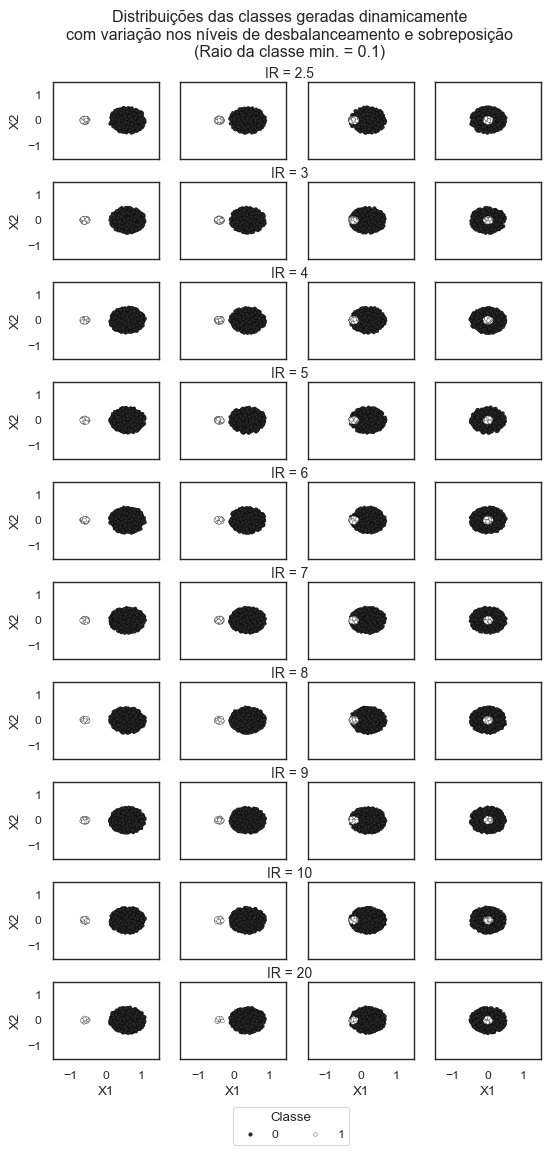

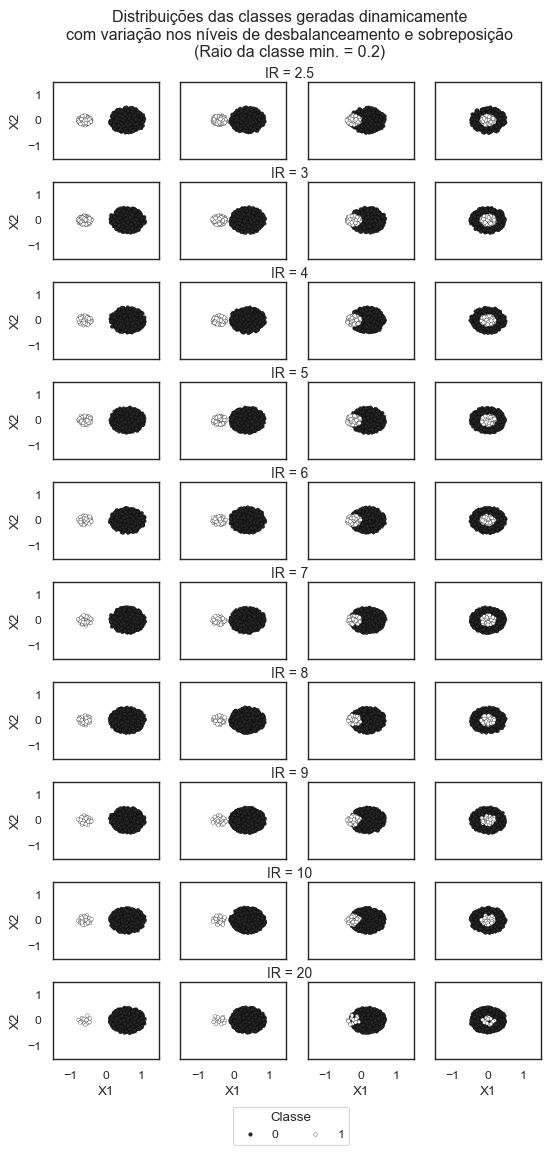

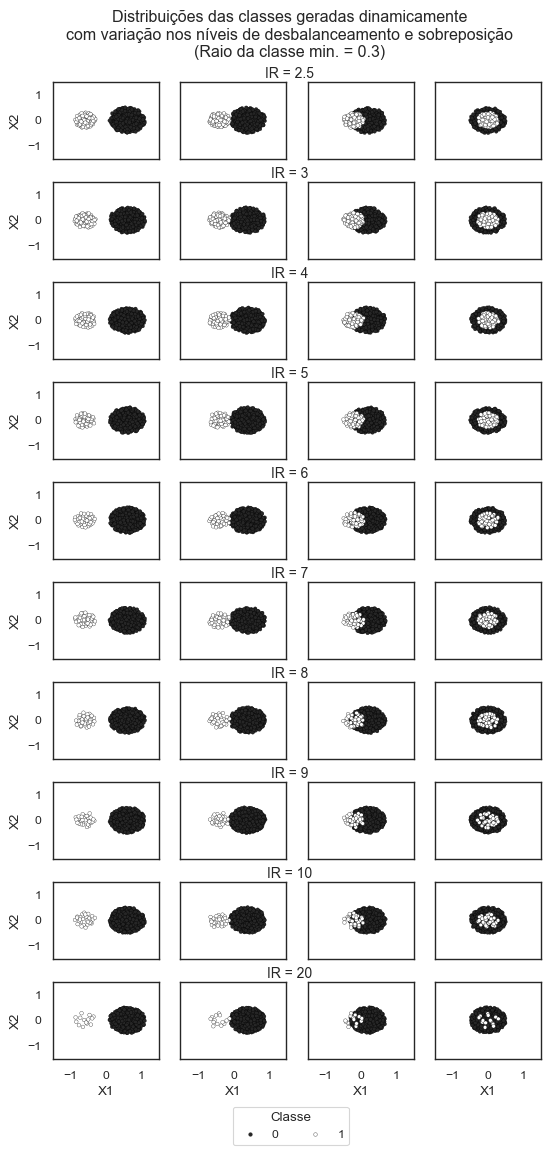

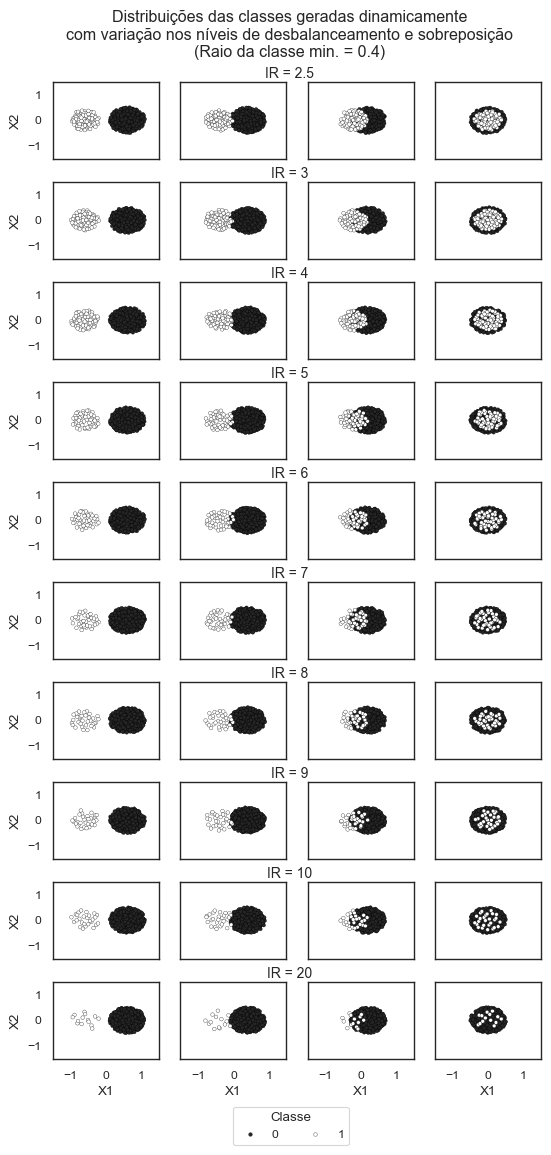

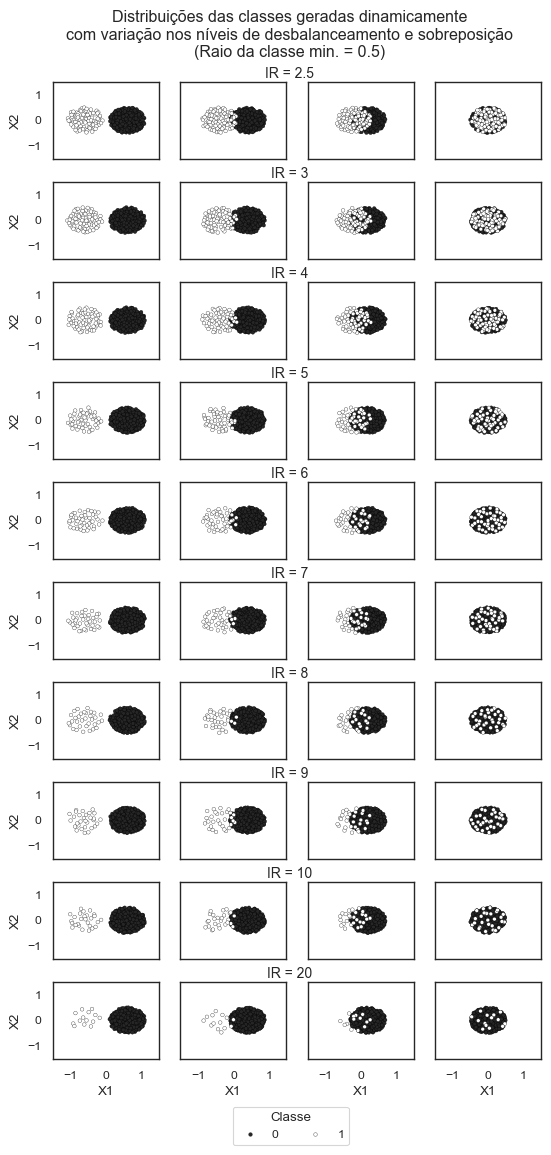

In [5]:
import os
import itertools
import pandas as pd
from scipy.io import arff
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

  
class_ratios = [
    '1:2.5', '1:3', '1:4', '1:5', '1:6', '1:7', '1:8',  
    '1:9', '1:10', '1:20'
]
class_1_centers = [f'{i/10}, 0' for i in range(-6, 2, 2)]
class_1_radius = [f'{i/10}, {i/10}' for i in range(1, 6, 1)]
class_2_centers = [f'{i/10}, 0' for i in range(6, -2, -2)]
sample_size = 300

total_ratios = len(class_ratios)
total_centers = len(class_1_centers)

sns.set_style('white')
sns.set_context("paper", font_scale = 1)

for i_radius, radius in enumerate(class_1_radius):
    radiusstr = radius[:3]
    radiusname = radiusstr.replace('.', '_')

    fig = plt.figure(
        figsize=(6.29707, 10),
    )

    fig.suptitle(
        (
            'Distribuições das classes geradas dinamicamente\n'
            'com variação nos níveis de desbalanceamento e sobreposição\n'
            f'(Raio da classe min. = {radiusstr})'
        ),
        y=1.06
    )

    subfigs = fig.subfigures(
        nrows=total_ratios,
        ncols=1,
    )

    for i_ratios, ratio in enumerate(class_ratios):
        ratio_str = ratio.split(':')[1]
        subfigs[i_ratios].suptitle(f'IR = {ratio_str}', y=1.03, fontsize=10)
        rationame = ratio.replace(':', 'to')
        # subfigs[i_ratios].set_facecolor(next(color))
        axs = subfigs[i_ratios].subplots(
            nrows=1,
            ncols=total_centers,
        )

        for i in range(len(class_1_centers)):

            class_1_center = class_1_centers[i]
            class_2_center = class_2_centers[i]
            distance = str(
                abs(
                    float(class_1_center.split(',')[0]) \
                    - float(class_2_center.split(',')[0])
                )
            ).replace('.', '_')
            
            dataset = f'spheres-2d-samples={sample_size}-radius={radiusname}-ratio={rationame}-distance={distance}'
            dataset_folder = f'data/spheres-2d/samples={sample_size}/radius={radiusname}/ratio={rationame}/distance={distance}'

            if not os.path.exists(dataset_folder): 
                os.makedirs(dataset_folder)

            arff_path = f'{dataset_folder}/{dataset}.arff'

            if not os.path.exists(arff_path):
                CONF_STRING = f"""
                    # {dataset}
                    attributes = 2
                    classes = 2
                    classRatio = {ratio}

                    names.attributes = X1, X2
                    names.classes = 1, 0
                    names.decision = Class
                    minOutlierDistance = 0

                    defaultRegion.weight = 1
                    defaultRegion.distribution = U
                    defaultRegion.noOutlierZone = 0


                    # MIN CLASS (1)
                    class.1.regions = 1
                    class.1.region.1.shape = C
                    class.1.region.1.center = {class_1_center}
                    class.1.region.1.radius = {radius}


                    # MAJ CLASS (0)
                    class.2.regions = 1
                    class.2.region.1.shape = C
                    class.2.region.1.center = {class_2_center}
                    class.2.region.1.radius = 0.5, 0.5

                    examples={sample_size}
                    fileName={dataset_folder}/{dataset}.arff
                """
                with open(f'{dataset_folder}/{dataset}.conf', 'w') as f:
                    f.write(CONF_STRING)

                print(f'Generating {dataset} arff...')
                os.system(f'java -jar data/datagenerator/experiments/DataGenSW.jar -config {dataset_folder}/{dataset}.conf')

            print(f'Loading {dataset}...')
            data = arff.loadarff(arff_path)
            df = pd.DataFrame(data[0])
            df['Class'] = df['Class'].astype(int)
        
            df.loc[df['Class'] == 1, 'Top'] = 2
            df.loc[df['Class'] == 0, 'Top'] = 1
            df = df.sort_values(by=['Top'], ascending=True)

            mks = itertools.cycle(['o', '+'])
            markers = [next(mks) for i in df["Class"].unique()]
            scatterplt = sns.scatterplot(
                data=df,
                x="X1",
                y="X2",
                hue="Class",
                legend=True,
                ax=axs[i],
                markers=markers,
                palette='dark:white',
                edgecolor='black',
                s=7
            )
            axs[i].set_xlim(-1.5, 1.5)
            axs[i].set_ylim(-1.5, 1.5)

            axs[i].set(xlabel=None, ylabel=None)                

            if i == 0:
                axs[i].set(ylabel='X2')
            else:
                axs[i].set_yticks([])           
            
            if i_ratios == total_ratios - 1:
                axs[i].set(xlabel='X1')  
            else:
                axs[i].set_xticks([])

            scatterplt.get_legend().remove()
            if i_ratios == total_ratios - 1 and i == total_centers - 1:
                scatterplt.legend(title='Classe', loc='lower center', bbox_to_anchor=(-1.36, -1.2), ncol=2)

            # print(f'Running estimator analysis for {dataset}...')
            # os.system(
            #     'python run_notebook.py '
            #     f'--dataset_path "{dataset_folder}/{dataset}.arff" '
            # )     

plt.show()

In [ ]:
dataset = 'creditcard'

print(f'Running estimator analysis for {dataset}...')
os.system(
    'python run_notebook.py '
    f'--dataset_path "{dataset_folder}/{dataset}.csv" '
)     